In [1]:
import os
# set working directory to root 
os.chdir('..')
os.getcwd()

'/home/qiangzibro/2021-math-model-code'

In [2]:
import pandas as pd, numpy as np
from common.io import load, load_table
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# Linux上解决字体问题
plt.rcParams['font.sans-serif']= ['Noto Serif CJK JP'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False 
FIGSIZE = (30, 25)
FORMAT = "pdf"

In [3]:
A = load_table("A")

In [4]:
A['1'].columns

Index(['Unnamed: 0', '监测时间', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)',
       'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '温度(℃)', '湿度(%)', '气压(MBar)', '风速(m/s)', '风向(°)'],
      dtype='object')

<AxesSubplot:xlabel='监测时间', ylabel='[SO2监测浓度(μg/m³)]'>

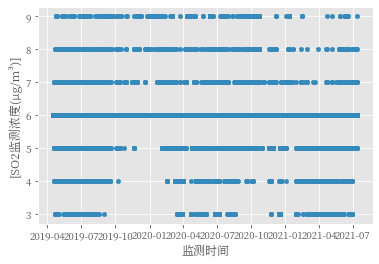

In [5]:
A['1'].plot.scatter(x='监测时间', y=['SO2监测浓度(μg/m³)'])

In [6]:
A['0']['SO2小时平均浓度(μg/m³)'].plot

In [7]:
A['0']['SO2小时平均浓度(μg/m³)'].plot.scatter

<bound method PlotAccessor.scatter of <pandas.plotting._core.PlotAccessor object at 0x7f473aa15490>>

# 1.时间特征

## 1.1 连续时间

持续时间：
浏览时长；
间隔时间：
购买/点击距今时长；
距离假期的前后时长（节假日前和节假日后可能会出现明显的数据波动）；
## 1.2 离散时间

年、季度、季节、月、星期、日、时 等；

基本特征，如果用 Xgboost 模型可以进行 one-hot 编码；
如果类别比较多，可以尝试平均数编码（Mean Encoding）。
或者取 cos/sin 将数值的首位衔接起来，比如说 23 点与 0 点很近，星期一和星期天很近。
节假日、节假日第 n 天、节假日前 n 天、节假日后 n 天；

数据可能会随着节假日的持续而发生变化，比如说递减；
节假日前/后可能会出现数据波动；
不放假的人造节日如 5.20、6.18、11.11 等也需要考虑一下；
一天的某个时间段；

上午、中午、下午、傍晚、晚上、深夜、凌晨等；
年初、年末、月初、月末、周内、周末；

基本特征；
高峰时段、是否上班、是否营业、是否双休日；

主要根据业务场景进行挖掘。

In [8]:
# 构造时间特征
def get_time_fe(data, col, n, one_hot=False, drop=True):
    '''
    data: DataFrame
    col: column name
    n: 时间周期
    '''
    data[col + '_sin'] = round(np.sin(2*np.pi / n * data[col]), 6)
    data[col + '_cos'] = round(np.cos(2*np.pi / n * data[col]), 6)
    if one_hot:
        ohe = OneHotEncoder()
        X = OneHotEncoder().fit_transform(data[col].values.reshape(-1, 1)).toarray()
        df = pd.DataFrame(X, columns=[col + '_' + str(int(i)) for i in range(X.shape[1])])
        data = pd.concat([data, df], axis=1)
    if drop:
        data = data.drop(col, axis=1)
    return data
data_df = A['1']

# 年、季度、季节、月、星期、日、时  
data_df['date'] = pd.to_datetime(data_df['监测时间'], format="%m/%d/%y")
data_df['quarter']=data_df['date'].dt.quarter
data_df['month'] = data_df['date'].dt.month
data_df['day'] = data_df['date'].dt.day
data_df['dayofweek'] = data_df['date'].dt.dayofweek
data_df['weekofyear'] = data_df['date'].dt.week   # 一年中的第几周

# Series.dt 下有很多属性，可以去看一下是否有需要的。
data_df['is_year_start'] = data_df['date'].dt.is_year_start
data_df['is_year_end'] = data_df['date'].dt.is_year_end
data_df['is_quarter_start'] = data_df['date'].dt.is_quarter_start
data_df['is_quarter_end'] = data_df['date'].dt.is_quarter_end
data_df['is_month_start'] = data_df['date'].dt.is_month_start
data_df['is_month_end'] = data_df['date'].dt.is_month_end

# data_df = get_time_fe(data_df, 'hour', n=24, one_hot=False, drop=False)
data_df = get_time_fe(data_df, 'day', n=31, one_hot=False, drop=True)
data_df = get_time_fe(data_df, 'dayofweek', n=7, one_hot=True, drop=True)
# data_df = get_time_fe(data_df, 'season', n=4, one_hot=True, drop=True)
data_df = get_time_fe(data_df, 'month', n=12, one_hot=True, drop=True)
data_df = get_time_fe(data_df, 'weekofyear', n=53, one_hot=False, drop=True)


/usr/miniconda3/envs/math/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [9]:
data_df.columns

Index(['Unnamed: 0', '监测时间', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)',
       'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '温度(℃)', '湿度(%)', '气压(MBar)', '风速(m/s)', '风向(°)', 'date', 'quarter',
       'is_year_start', 'is_year_end', 'is_quarter_start', 'is_quarter_end',
       'is_month_start', 'is_month_end', 'day_sin', 'day_cos', 'dayofweek_sin',
       'dayofweek_cos', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'month_sin',
       'month_cos', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'weekofyear_sin', 'weekofyear_cos'],
      dtype='object')

# 2. 聚合特征
## 2.1 统计值
基于历史数据构造长中短期的统计值，包括前 n 天/周期内的：

四分位数；
中位数、平均数、偏差；
偏度、峰度；
挖掘数据的偏离程度和集中程度；
离散系数；
挖掘离散程度
这里可以用自相关系数（autocorrelation）挖掘出周期性。

除了对数据进行统计外，也可以对节假日等进行统计，以刻画历史数据中所含节假日的情况。（还可以统计未来的节假日的情况。）

In [10]:
# 画出自相关性系数图
from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(data['value'])

# 构造过去 n 天的统计数据
def get_statis_n_days_num(data, col, n):
    temp = pd.DataFrame()
    for i in range(n):
        temp = pd.concat([temp, data[col].shift((i+1)*24)], axis=1)
        data['avg_'+ str(n) +'_days_' + col] = temp.mean(axis=1)
        data['median_'+ str(n) +'_days_' + col] = temp.median(axis=1)
        data['max_'+ str(n) +'_days_' + col] = temp.max(axis=1)
        data['min_'+ str(n) +'_days_' + col] = temp.min(axis=1)
        data['std_'+ str(n) +'_days_' + col] = temp.std(axis=1)
        data['mad_'+ str(n) +'_days_' + col] = temp.mad(axis=1)
        data['skew_'+ str(n) +'_days_' + col] = temp.skew(axis=1)
        data['kurt_'+ str(n) +'_days_' + col] = temp.kurt(axis=1)
        data['q1_'+ str(n) +'_days_' + col] = temp.quantile(q=0.25, axis=1)
        data['q3_'+ str(n) +'_days_' + col] = temp.quantile(q=0.75, axis=1)
        data['var_'+ str(n) +'_days_' + col] = data['std_'+ str(n) +'_days_' + col]/data['avg_'+ str(n) +'_days_' + col]  # 离散系数
    return data

data_df = get_statis_n_days_num(data_df, 'SO2监测浓度(μg/m³)', n=7)
data_df = get_statis_n_days_num(data_df, 'SO2监测浓度(μg/m³)', n=14)
data_df = get_statis_n_days_num(data_df, 'SO2监测浓度(μg/m³)', n=21)
data_df = get_statis_n_days_num(data_df, 'SO2监测浓度(μg/m³)', n=28)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

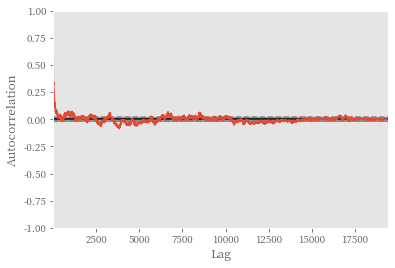

In [11]:
autocorrelation_plot(data_df['SO2监测浓度(μg/m³)'])

In [12]:
import matplotlib    
print(matplotlib.matplotlib_fname())


/usr/miniconda3/envs/math/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc


In [13]:
y = [
    'q1_'+ str(7) +'_days_SO2监测浓度(μg/m³)',
    'q3_'+ str(7) +'_days_SO2监测浓度(μg/m³)',
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title=None, figsize=(15,8))
plt.savefig("results/q1_q3_so2."+FORMAT, format=FORMAT)
plt.close()

<AxesSubplot:title={'center':'过去时间段监测SO2监测浓度均值'}, xlabel='date'>

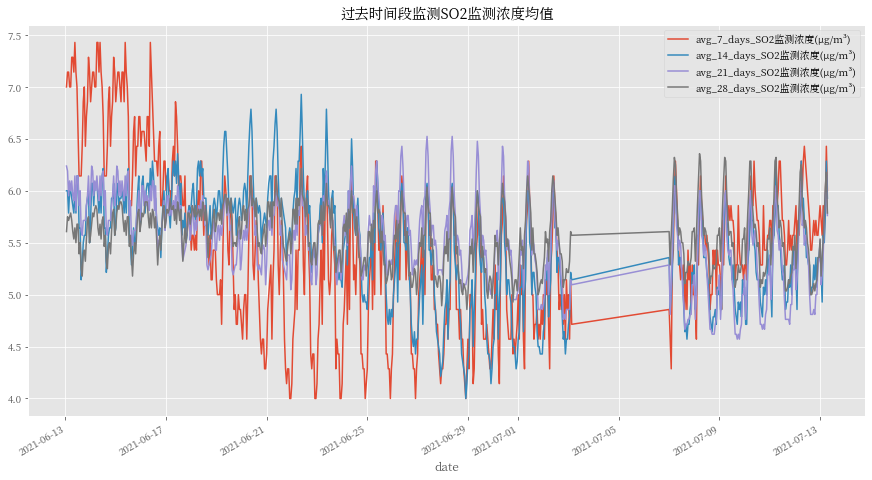

In [14]:
# 过去时间段监测浓度均值
y = [
    'avg_'+ str(i) +'_days_SO2监测浓度(μg/m³)' for i in [7, 14, 21, 28]
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title='过去时间段监测SO2监测浓度均值', figsize=(15,8))

<AxesSubplot:title={'center':'过去时间段监测SO2监测浓度方差'}, xlabel='date'>

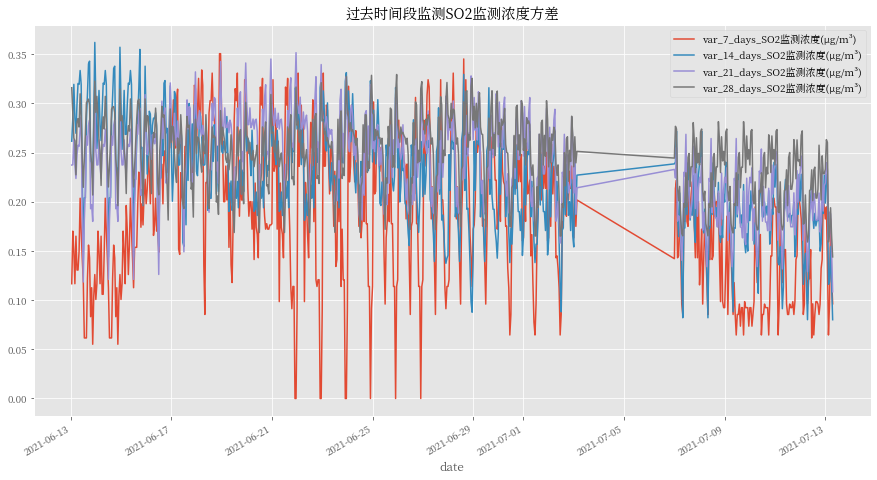

In [15]:
y = [
    'var_'+ str(i) +'_days_SO2监测浓度(μg/m³)' for i in [7, 14, 21, 28]
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title='过去时间段监测SO2监测浓度方差', figsize=(15,8))

## 2.2 同期值
前 n 个周期/天/月/年的同期值；

In [16]:
# n 个星期前同期特征
data_df['ago_7_day_SO2监测浓度(μg/m³)'] = data_df['SO2监测浓度(μg/m³)'].shift(7*24)
data_df['ago_14_day_SO2监测浓度(μg/m³)'] = data_df['SO2监测浓度(μg/m³)'].shift(14*24)
data_df['ago_21_day_SO2监测浓度(μg/m³)'] = data_df['SO2监测浓度(μg/m³)'].shift(21*24)
data_df['ago_28_day_SO2监测浓度(μg/m³)'] = data_df['SO2监测浓度(μg/m³)'].shift(28*24)

# # 昨天的同期特征
data_df['ago_1_day_SO2监测浓度(μg/m³)'] = data_df['SO2监测浓度(μg/m³)'].shift(1*24)

<AxesSubplot:xlabel='date'>

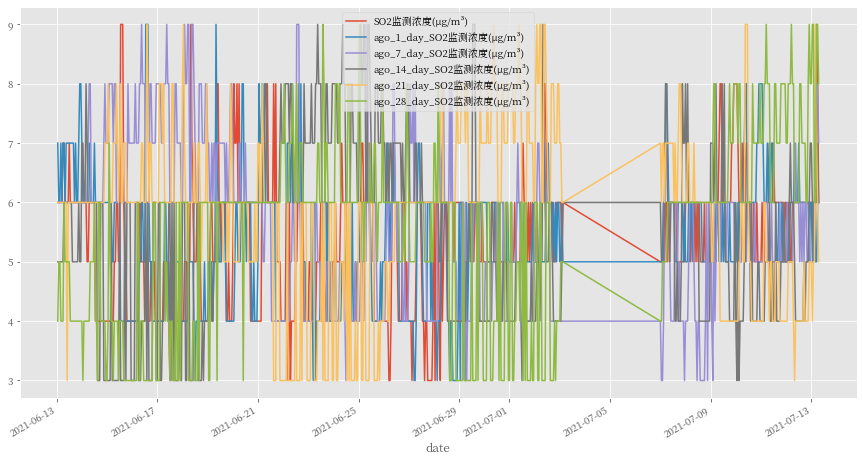

In [17]:
y = [
    'SO2监测浓度(μg/m³)',
    'ago_1_day_SO2监测浓度(μg/m³)',
    'ago_7_day_SO2监测浓度(μg/m³)',
    'ago_14_day_SO2监测浓度(μg/m³)',
    'ago_21_day_SO2监测浓度(μg/m³)',
    'ago_28_day_SO2监测浓度(μg/m³)'
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title=None, figsize=(15,8))

# 3.交叉特征

类别特征间组合构成新特征：

笛卡尔积，比如星期和小时：Mon_10（星期一的十点）；

类别特征和连续特征：

连续特征分桶后进行笛卡尔积；

基于类别特征进行 groupby 操作，类似聚合特征的构造；

连续特征和连续特征：

同比和环比（一阶差分）：反应同期或上一个统计时段的变换大小；

二阶差分：反应变化趋势；

比值；
特征交叉一般从重要特征线下手，慢工出细活。

In [18]:
# 一阶差分
data_df['ago_28_21_day_SO2监测浓度(μg/m³)_trend'] = data_df['ago_28_day_SO2监测浓度(μg/m³)'] - data_df['ago_21_day_SO2监测浓度(μg/m³)']
data_df['ago_21_14_day_SO2监测浓度(μg/m³)_trend'] = data_df['ago_21_day_SO2监测浓度(μg/m³)'] - data_df['ago_14_day_SO2监测浓度(μg/m³)']
data_df['ago_14_7_day_SO2监测浓度(μg/m³)_trend'] = data_df['ago_14_day_SO2监测浓度(μg/m³)'] - data_df['ago_7_day_SO2监测浓度(μg/m³)']
data_df['ago_7_1_day_SO2监测浓度(μg/m³)_trend'] = data_df['ago_7_day_SO2监测浓度(μg/m³)'] - data_df['ago_1_day_SO2监测浓度(μg/m³)']

<AxesSubplot:xlabel='date'>

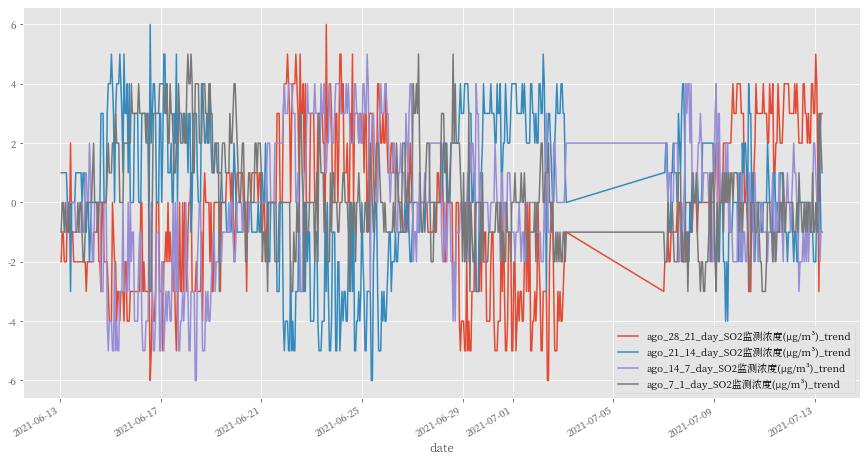

In [19]:
y = [
    'ago_28_21_day_SO2监测浓度(μg/m³)_trend',
    'ago_21_14_day_SO2监测浓度(μg/m³)_trend',
    'ago_14_7_day_SO2监测浓度(μg/m³)_trend',
    'ago_7_1_day_SO2监测浓度(μg/m³)_trend'
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title=None, figsize=(15,8))

# Thanks
1. 【时间序列】时序特征挖掘的奇技淫巧，阿泽，https://mp.weixin.qq.com/s/j-TBNSSCafeqE8qkfeF9qw